In [8]:
! pip install -U pip -q
! pip install datasets -q
! pip install umap-learn -q

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from datasets import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_chkpt = "distilbert-base-uncased"
data = 'emotion'

# load the data
emotions = load_dataset(data)

# load tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_chkpt)
model = AutoModel.from_pretrained(model_chkpt).to(device)

# tokenize data
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=False)
print(emotions_encoded.column_names)

# process the data with model base
# to generate featuers
# train classifier
# use dataset map method
def extract_hidden_states(batch):
  inputs = {k: v.to(device) for k, v in batch.items()
  if k in tokenizer.model_input_names}

  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

emotions_encoded.set_format(
    'torch', columns=['input_ids', 'attention_mask', 'label']
    )
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
print('hidden state column names')
print(emotions_hidden.column_names)

## creating features
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
print('shape of train and validation data')
print(X_train.shape, X_valid.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/loca

{'train': ['text', 'label', 'input_ids', 'attention_mask'], 'validation': ['text', 'label', 'input_ids', 'attention_mask'], 'test': ['text', 'label', 'input_ids', 'attention_mask']}
hidden state column names
{'train': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'], 'validation': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'], 'test': ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']}
shape of train and validation data
(16000, 768) (2000, 768)


- Transform the hidden state to 2 dim
- MinMaxScalar
  - UMPA works better when the data between [0, 1]
  

In [11]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.227013,6.578702,0
1,-3.335188,5.772254,0
2,5.300342,3.150420,3
3,-2.631904,3.634766,2
4,-3.460131,3.843496,3


## Plot the hidden state
  - extract the feature by the model base

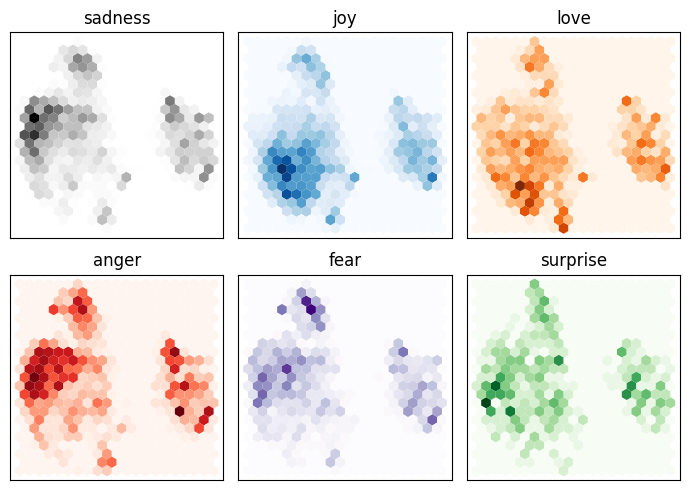

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f'label == {i}')
  axes[i].hexbin(
      df_emb_sub['X'], df_emb_sub['Y'], cmap=cmap, gridsize=20, linewidth=(0, )
      )
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

## fit a simple classifier

In [18]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [19]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

## Confussion metrics
- generate confussion metrix
- plot the confussion metrics

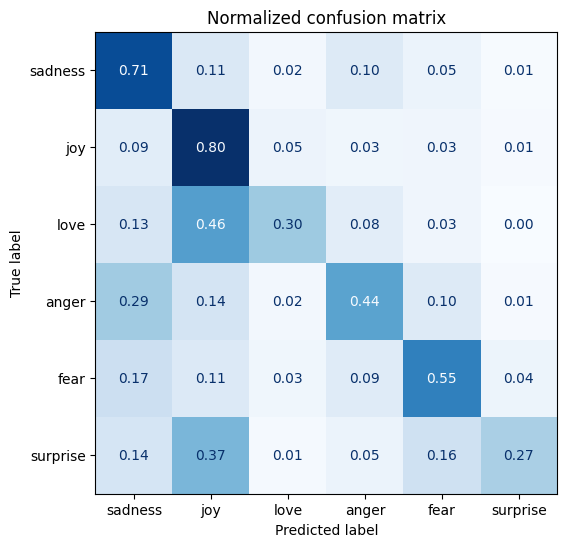

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

- anger and fear are classified as sadness (look at the true label side)

## Fine-Tune Transformers
- end to end
- 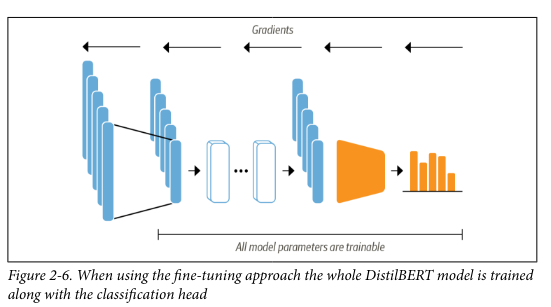
- Trainer API
- AutoModelForSequenceClassification model
  - has classification head on top of the pretrained model

- Define performance metircs

In [1]:
# ! pip install datasets -q
# ! pip install transformers[torch] -q
# ! pip install transformers==4.30 -q

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = 'emotion'
num_labels = 6
model_chkpt = "distilbert-base-uncased"

# data prepration
emotions = load_dataset(data)
tokenizer = AutoTokenizer.from_pretrained(model_chkpt)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=False)

# emotions_encoded.set_format(
#     'torch', columns=['input_ids', 'attention_mask', 'label']
#     )

# model
model = AutoModelForSequenceClassification\
  .from_pretrained(model_chkpt, num_labels=num_labels)\
  .to(device)

# evaluation metircs
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1':f1}

# trainer -> hyperparameters
batch_size = 6
logging_steps = len(emotions_encoded['train'])//batch_size
model_name = f'{model_chkpt}-finetuned-emotion'
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error"
)

# trainer
trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

trainer.train()

2024-05-08 19:05:56.557984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-08 19:05:56.558003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClas

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.446100,0.249611,0.934500,0.934675
2,0.184200,0.182122,0.935000,0.934949
3,0.113400,0.215649,0.937000,0.937348


Attempted to log scalar metric loss:
0.4461
Attempted to log scalar metric learning_rate:
1.3335833020872393e-05
Attempted to log scalar metric epoch:
1.0
Attempted to log scalar metric eval_loss:
0.24961070716381073
Attempted to log scalar metric eval_accuracy:
0.9345
Attempted to log scalar metric eval_f1:
0.9346754179057642
Attempted to log scalar metric eval_runtime:
30.5803
Attempted to log scalar metric eval_samples_per_second:
65.402
Attempted to log scalar metric eval_steps_per_second:
10.922
Attempted to log scalar metric epoch:
1.0
Attempted to log scalar metric loss:
0.1842
Attempted to log scalar metric learning_rate:
6.671666041744782e-06
Attempted to log scalar metric epoch:
2.0
Attempted to log scalar metric eval_loss:
0.18212200701236725
Attempted to log scalar metric eval_accuracy:
0.935
Attempted to log scalar metric eval_f1:
0.9349487054246053
Attempted to log scalar metric eval_runtime:
31.6948
Attempted to log scalar metric eval_samples_per_second:
63.102
Attempted

TrainOutput(global_step=8001, training_loss=0.24781839016425938, metrics={'train_runtime': 4300.6676, 'train_samples_per_second': 11.161, 'train_steps_per_second': 1.86, 'total_flos': 1080514292544000.0, 'train_loss': 0.24781839016425938, 'epoch': 3.0})

In [3]:
import numpy as np
preds_output = trainer.predict(emotions_encoded['validation'])
# since labels are supplied
# the predict method will generae the metrics we have defined
print(preds_output.metrics)

# the raw predictions can be accessed by
y_pred = np.argmax(preds_output.predictions, axis=1)

{'test_loss': 0.21564877033233643, 'test_accuracy': 0.937, 'test_f1': 0.9373480538685273, 'test_runtime': 27.0974, 'test_samples_per_second': 73.808, 'test_steps_per_second': 12.326}


## print confussion metrics

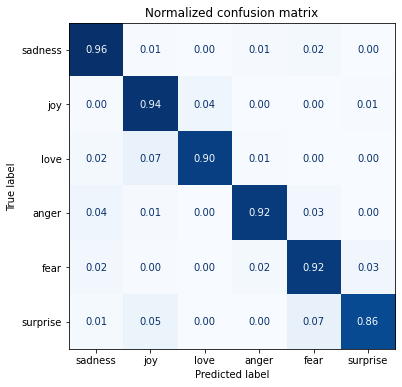

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt

labels = emotions['validation'].features['label'].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_valid = emotions_encoded['validation']['label']
plot_confusion_matrix(y_pred, y_valid, labels)

## Tensorflow way of fine-tuning

In [ ]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

tf_model = TFAutoModelForSequenceClassification\
    .from_pretrained(model_chkpt, num_labels=num_labels)

# columns need to converted to tensorflow tensor
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded['train'].to_tf_dataset(
    columns=tokenizer_columns, label_cols=['label'], 
    shuffle=True, batch_size=batch_size
)

tf_eval_dataset = emotions_encoded['validation'].to_tf_dataset(
    columns=tokenizer_columns, label_cols=['label'], 
    shuffle=True, batch_size=batch_size
)

tf_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

tf_model.fit(
    tf_train_dataset, validation_data=tf_eval_dataset, epochs=2
)

Epoch 1/2
 945/2667 [=========>....................] - ETA: 54:42 - loss: 0.6097 - sparse_categorical_accuracy: 0.7929

## Error Analysis
- find the loss for every prediction
- what is the prediction & true label for low error and high value of error

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokeninzer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(
            output.logits, 
            battch['label'].to(device),
            reduction = 'none' #reduction for finding single value for comparison
        )
    return {
        'loss': loss.cpu().numpy(),
        'predicted_label': pred_label.cpu().numpy()
    }

# map function to add both the columns to the dataset
emotions.set_fromat(
    'troch',
    columns=['input_ids', 'attention_mask', 'label']
)
emotions_encoded['validation'] = emotion_encoded['validation'].map(
    forward_pass_with_label, batched=True, batch_size=16
)

emotions.set_format('pandas')
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
 .apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

## Save a model

In [ ]:
trainer.save_model("path/to/model")
# another way to save model
model.save_pretrained("path/to/model")
# load the model back
AutoModelForSequenceClassification\
.from_pretrained("path/to/model")